# Installing Anomalib

To install anomalib with the required dependencies, please follow the steps under `Install from source` [on GitHub](https://github.com/openvinotoolkit/anomalib?tab=readme-ov-file#-installation).

## Imports


In [1]:
# NOTE: Provide the path to the dataset root directory.
#   If the datasets is not downloaded, it will be downloaded
#   to this directory.
dataset_root = "/home/azureuser/cloudfiles/code/Users/rohit.potdukhe/Package6941_modified"

In [2]:
from lightning.pytorch.callbacks import EarlyStopping, ModelCheckpoint
from matplotlib import pyplot as plt
from PIL import Image
from IPython.display import display
import torch
from pathlib import Path

from anomalib.data import PredictDataset, Folder
from anomalib.engine import Engine
from anomalib.models import Patchcore
from anomalib import TaskType
from anomalib.loggers import AnomalibTensorBoardLogger
from anomalib.data.utils import read_image
from anomalib.deploy import OpenVINOInferencer
from anomalib.utils.normalization import NormalizationMethod
import os, pprint, yaml, warnings, math, glob, cv2, random, logging
%matplotlib inline
torch.cuda.empty_cache()

### Dataset

Prepare your own dataset for normal and defect pieces.


In [3]:
datamodule = Folder(
    name="ipig_package6941_modified",
    root= dataset_root,
    normal_dir="train/FC",
    abnormal_dir="train/NG",
    # val_path=Path.cwd() / "images" / "val",
    normal_split_ratio=0.2,
    image_size=(256, 256),
    train_batch_size=16,
    eval_batch_size=16,
    task=TaskType.CLASSIFICATION,
    num_workers=0
)
datamodule.setup()
datamodule.prepare_data()

i, data = next(enumerate(datamodule.test_dataloader()))
print(data["image"].shape)

torch.Size([16, 3, 256, 256])


## Model

`anomalib` supports a wide range of unsupervised anomaly detection models. The table in this [link](https://anomalib.readthedocs.io/en/latest/markdown/guides/reference/models/image/index.html) shows the list of models currently supported by `anomalib` library.


### Prepare the Model



In [4]:
#ResNet50, WideResNet50, ResNet101, WideResNet101, ResNeXt101
#wide_resnet50_2. Available layers: ['act1', 'layer1', 'layer2', 'layer3', 'layer4']
model = Patchcore(
    backbone="wide_resnet50_2", 
    layers=["act1"]
)

## Training

Now that we set up the datamodule and model, we could now train the model.

The final component to train the model is `Engine` object, which handles train/test/predict/export pipeline. Let's create the engine object to train the model.


In [5]:
engine = Engine(
    normalization=NormalizationMethod.MIN_MAX,
    threshold="F1AdaptiveThreshold",
    task=TaskType.CLASSIFICATION,
    image_metrics=["AUROC", "F1Score"],
    accelerator="cpu",
    check_val_every_n_epoch=1,
    devices='auto',
    max_epochs=1,
    num_sanity_val_steps=0,
    val_check_interval=1.0,
)

In [ ]:
engine.fit(model=model, datamodule=datamodule)

In [11]:
"""model = Patchcore(
    backbone="wide_resnet50_2", 
    layers=["layer2", "layer3"]
)"""

test_results = engine.test(model=model, datamodule=datamodule)

Testing ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12/12 0:01:52 • 0:00:00 0.13it/s

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        image_AUROC        │    0.8816406726837158     │
│       image_F1Score       │     0.885993480682373     │
└───────────────────────────┴───────────────────────────┘

In [ ]:
"""model = Patchcore(
    backbone="wide_resnet50_2", 
    layers=["act1"]
)"""

test_results = engine.test(model=model, datamodule=datamodule)

In [13]:
"""model = Patchcore(
    backbone="wide_resnet50_2", 
    layers=["layer1", "layer2"]
)"""

test_results = engine.test(model=model, datamodule=datamodule)

Testing ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12/12 0:04:51 • 0:00:00 0.04it/s

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        image_AUROC        │    0.9271483421325684     │
│       image_F1Score       │    0.9433962106704712     │
└───────────────────────────┴───────────────────────────┘

In [24]:
"""model = Patchcore(
    backbone="wide_resnet50_2", 
    layers=["layer2", "layer3", "layer4"]
)"""

test_results = engine.test(model=model, datamodule=datamodule)

Testing ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12/12 0:02:34 • 0:00:00 0.08it/s

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        image_AUROC        │    0.8806641101837158     │
│       image_F1Score       │    0.9108280539512634     │
└───────────────────────────┴───────────────────────────┘

In [ ]:
from anomalib.deploy import ExportType

export_root = Path.cwd() / 'patchCore_WRN50_weights'

export_root.mkdir(parents=True, exist_ok=True)

# Exporting model to OpenVINO
openvino_model_path = engine.export(
    model=model,
    export_type=ExportType.OPENVINO,
    export_root=str(export_root),
)

## OpenVINO Inference

Now that we trained and tested a model, we could check a single inference result using OpenVINO inferencer object. This will demonstrate how a trained model could be used for inference.


## Prediction on all images

In [27]:
def inference(dataset_path, label):
    
    predictions = []

    image_paths = list(dataset_path.glob("**/*.jpg"))

    for image_path in image_paths:
        image = read_image(image_path)

        prediction = inferencer.predict(image=image)
        predictions.append((image_path, prediction, label))
    
    return predictions

In [28]:
def process_all_predictions(normal_predictions, abnormal_predictions):
    all_predictions = []
    all_labels = []
    misclassified_files = []

    # Process normal predictions
    for file_path, image_result, _ in normal_predictions:
        pred_label = 1 if image_result.pred_label else 0
        all_predictions.append(pred_label)
        all_labels.append(0)  # 0 for normal
        if pred_label != 0:
            misclassified_files.append((file_path, 'Normal', 'Predicted as Abnormal'))

    # Process abnormal predictions
    for file_path, image_result, _ in abnormal_predictions:
        pred_label = 1 if image_result.pred_label else 0
        all_predictions.append(pred_label)
        all_labels.append(1)  # 1 for abnormal
        if pred_label != 1:
            misclassified_files.append((file_path, 'Abnormal', 'Predicted as Normal'))
        
    return all_predictions, all_labels, misclassified_files

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def plot_confusion_matrix(y_true, y_pred):

    classes = ['Normal', 'Abnormal']
    cm = confusion_matrix(y_true, y_pred)

    # Create a figure and a set of subplots
    plt.figure(figsize=(8, 6))
    # Create a heatmap
    sns.heatmap(cm, annot=True, fmt='d', cmap=plt.cm.Blues, xticklabels=classes, yticklabels=classes)
    plt.title('Confusion Matrix')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    plt.show()

## Inference
model = Patchcore(
    backbone="wide_resnet50_2", 
    layers=["layer3", "layer4"]
)

In [45]:
metadata_path = openvino_model_path.parent / "metadata.json"
print(openvino_model_path.exists(), metadata_path.exists())

True True


In [52]:
inferencer = OpenVINOInferencer(
    path=openvino_model_path,  # Path to the OpenVINO IR model.
    metadata=metadata_path,  # Path to the metadata file.
    device="CPU",  
)

normal_img_path = Path("/home/azureuser/cloudfiles/code/Users/rohit.potdukhe/Package6941_modified/val/FC")
abnormal_img_path = Path("/home/azureuser/cloudfiles/code/Users/rohit.potdukhe/Package6941_modified/val/NG")

normal_predictions = inference(normal_img_path, label = "normal")
abnormal_predictions = inference(abnormal_img_path, label = "abnormal")

In [53]:
all_predictions, all_labels, misclassified_files = process_all_predictions(normal_predictions, abnormal_predictions)

In [54]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Calculate accuracy, precision, recall, and F1 score
accuracy = accuracy_score(all_labels, all_predictions)
precision = precision_score(all_labels, all_predictions)
recall = recall_score(all_labels, all_predictions)
f1 = f1_score(all_labels, all_predictions)

# Display the metrics
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

Accuracy: 0.5125
Precision: 0.5063291139240507
Recall: 1.0
F1 Score: 0.6722689075630253


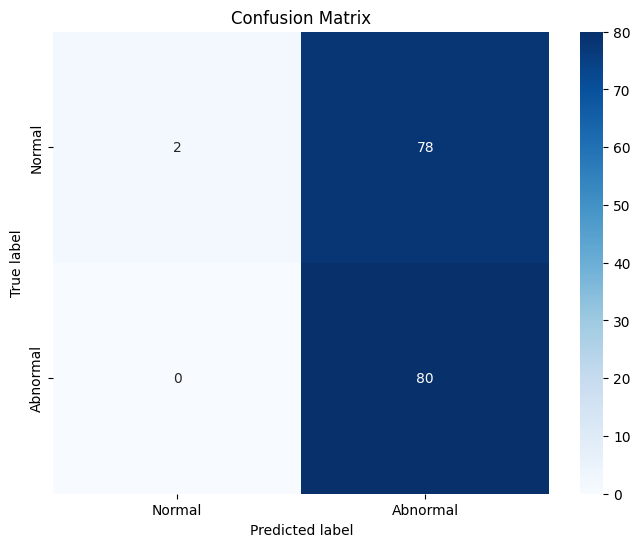

In [55]:
%matplotlib inline

plot_confusion_matrix(all_labels, all_predictions)

## Inference
model = Patchcore(
    backbone="wide_resnet50_2", 
    layers=["layer2", "layer3"]
)

In [21]:
metadata_path = openvino_model_path.parent / "metadata.json"
print(openvino_model_path.exists(), metadata_path.exists())

inferencer = OpenVINOInferencer(
    path=openvino_model_path,  # Path to the OpenVINO IR model.
    metadata=metadata_path,  # Path to the metadata file.
    device="CPU",  
)

True True


In [22]:
normal_img_path = Path("/home/azureuser/cloudfiles/code/Users/rohit.potdukhe/Package6941_modified/val/FC")
abnormal_img_path = Path("/home/azureuser/cloudfiles/code/Users/rohit.potdukhe/Package6941_modified/val/NG")

normal_predictions = inference(normal_img_path, label = "normal")
abnormal_predictions = inference(abnormal_img_path, label = "abnormal")

In [23]:
all_predictions, all_labels, misclassified_files = process_all_predictions(normal_predictions, abnormal_predictions)

In [24]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Calculate accuracy, precision, recall, and F1 score
accuracy = accuracy_score(all_labels, all_predictions)
precision = precision_score(all_labels, all_predictions)
recall = recall_score(all_labels, all_predictions)
f1 = f1_score(all_labels, all_predictions)

# Display the metrics
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

Accuracy: 0.8375
Precision: 0.7647058823529411
Recall: 0.975
F1 Score: 0.8571428571428571


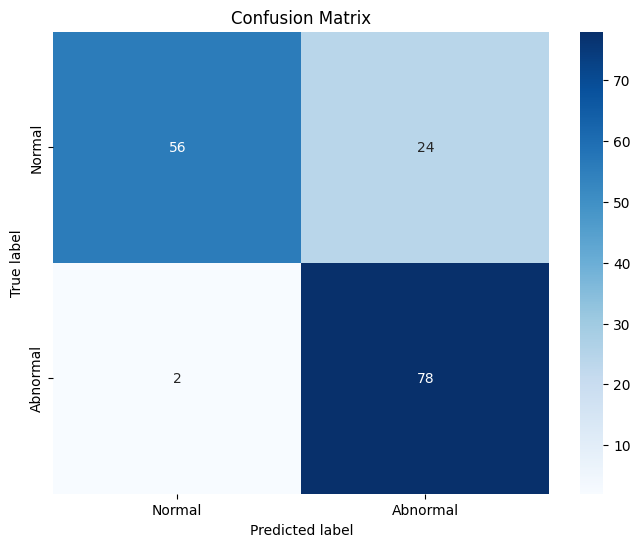

In [25]:
%matplotlib inline

plot_confusion_matrix(all_labels, all_predictions)

## Inference
model = Patchcore(
    backbone="wide_resnet50_2", 
    layers=["layer1", "layer2"]
)

In [18]:
metadata_path = openvino_model_path.parent / "metadata.json"
print(openvino_model_path.exists(), metadata_path.exists())

inferencer = OpenVINOInferencer(
    path=openvino_model_path,  # Path to the OpenVINO IR model.
    metadata=metadata_path,  # Path to the metadata file.
    device="CPU",  
)

normal_img_path = Path("/home/azureuser/cloudfiles/code/Users/rohit.potdukhe/Package6941_modified/val/FC")
abnormal_img_path = Path("/home/azureuser/cloudfiles/code/Users/rohit.potdukhe/Package6941_modified/val/NG")

normal_predictions = inference(normal_img_path, label = "normal")
abnormal_predictions = inference(abnormal_img_path, label = "abnormal")

all_predictions, all_labels, misclassified_files = process_all_predictions(normal_predictions, abnormal_predictions)

True True


In [19]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Calculate accuracy, precision, recall, and F1 score
accuracy = accuracy_score(all_labels, all_predictions)
precision = precision_score(all_labels, all_predictions)
recall = recall_score(all_labels, all_predictions)
f1 = f1_score(all_labels, all_predictions)

# Display the metrics
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

Accuracy: 0.9125
Precision: 0.8666666666666667
Recall: 0.975
F1 Score: 0.9176470588235294


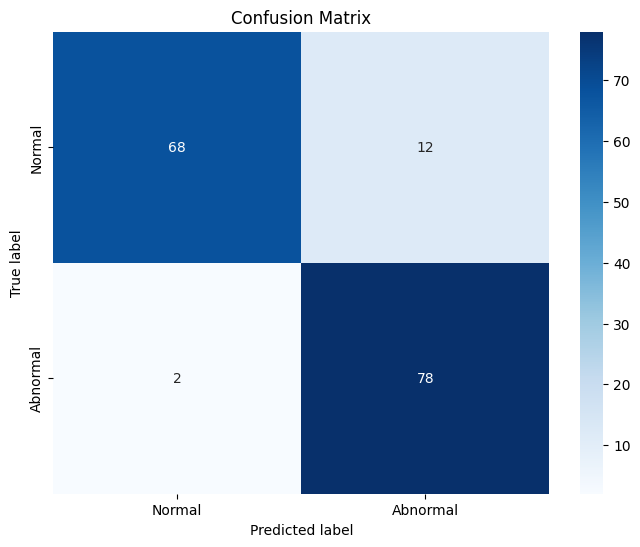

In [20]:
%matplotlib inline

plot_confusion_matrix(all_labels, all_predictions)

## Inference
model = Patchcore(
    backbone="wide_resnet50_2", 
    layers=["layer2", "layer3", "layer4"]
)

In [30]:
metadata_path = openvino_model_path.parent / "metadata.json"
print(openvino_model_path.exists(), metadata_path.exists())

inferencer = OpenVINOInferencer(
    path=openvino_model_path,  # Path to the OpenVINO IR model.
    metadata=metadata_path,  # Path to the metadata file.
    device="CPU",  
)

normal_img_path = Path("/home/azureuser/cloudfiles/code/Users/rohit.potdukhe/Package6941_modified/val/FC")
abnormal_img_path = Path("/home/azureuser/cloudfiles/code/Users/rohit.potdukhe/Package6941_modified/val/NG")

normal_predictions = inference(normal_img_path, label = "normal")
abnormal_predictions = inference(abnormal_img_path, label = "abnormal")

all_predictions, all_labels, misclassified_files = process_all_predictions(normal_predictions, abnormal_predictions)

True True


In [31]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Calculate accuracy, precision, recall, and F1 score
accuracy = accuracy_score(all_labels, all_predictions)
precision = precision_score(all_labels, all_predictions)
recall = recall_score(all_labels, all_predictions)
f1 = f1_score(all_labels, all_predictions)

# Display the metrics
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

Accuracy: 0.7625
Precision: 0.6810344827586207
Recall: 0.9875
F1 Score: 0.8061224489795918


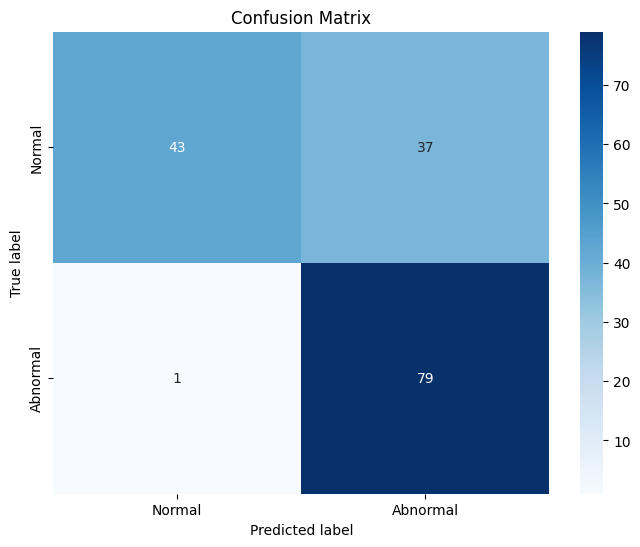

In [32]:
%matplotlib inline

plot_confusion_matrix(all_labels, all_predictions)

## Inference with
model = Patchcore(
    backbone="wide_resnet50_2", 
    layers=["act1"]
)

In [ ]:
metadata_path = openvino_model_path.parent / "metadata.json"
print(openvino_model_path.exists(), metadata_path.exists())

inferencer = OpenVINOInferencer(
    path=openvino_model_path,  # Path to the OpenVINO IR model.
    metadata=metadata_path,  # Path to the metadata file.
    device="CPU",  
)

normal_img_path = Path("/home/azureuser/cloudfiles/code/Users/rohit.potdukhe/Package6941_modified/val/FC")
abnormal_img_path = Path("/home/azureuser/cloudfiles/code/Users/rohit.potdukhe/Package6941_modified/val/NG")

normal_predictions = inference(normal_img_path, label = "normal")
abnormal_predictions = inference(abnormal_img_path, label = "abnormal")

all_predictions, all_labels, misclassified_files = process_all_predictions(normal_predictions, abnormal_predictions)

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Calculate accuracy, precision, recall, and F1 score
accuracy = accuracy_score(all_labels, all_predictions)
precision = precision_score(all_labels, all_predictions)
recall = recall_score(all_labels, all_predictions)
f1 = f1_score(all_labels, all_predictions)

# Display the metrics
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

In [ ]:
%matplotlib inline

plot_confusion_matrix(all_labels, all_predictions)